In [ ]:
# from dataprocess.kdd_cup99 import KDD_CUP_99_DataLoader
from dataprocess.unsw_nb15 import UNSW_NB15_DataLoader
from net.CNN import CNN, CNN_2_linear
from net.multCNN import multCNN

: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# dataset = KDD_CUP_99_DataLoader('E:/DataSets/kddcup.data', 256, 'Test')
dataset = UNSW_NB15_DataLoader('E:/DataSets/UNSW-NB15 - CSV Files', 256, 'Test')
labels = dataset.data.label_dic.keys()
class_num = len(labels)
discrete_column_idx = dataset.data.discrete_column
discrete_column_idx.remove(47)
discrete_column_idx.remove(48)
continuous_column_idx = [i for i in range(47) if i not in discrete_column_idx]
input_channel_kind = len(discrete_column_idx)
input_channel_num = len(continuous_column_idx)
print(discrete_column_idx, continuous_column_idx, labels)

[0, 1, 2, 3, 4, 5, 13, 35, 38, 41] [6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 39, 40, 42, 43, 44, 45, 46] dict_keys([b'Normal', b'Generic', b'Exploits', b'Fuzzers', b'DoS', b' Reconnaissance', b'Analysis', b'Backdoors', b'Shellcode', b'Worms'])


In [5]:
# U2R_list = [b'loadmodule.', b'buffer_overflow.', b'perl.', b'rootkit.']
# # index = dataset.data.to_num_column_dic[41]
# # print(index)
# U2R_indices = [12, 16, 17, 21]

In [5]:
log_file = 'history/CNN_2_linear/UNSW_NB15/plot/confusion_matrix/5_6'
if not os.path.isdir(log_file):
    os.makedirs(log_file)

In [6]:
ckpt_file = 'history/CNN_2_linear/UNSW_NB15/checkpoint/5_6/ckpt_best_29.pth'
net = CNN_2_linear(input_channel_num + input_channel_kind, class_num).to(device)
checkpoint = torch.load(ckpt_file)
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [7]:
# # for kdd_dup99
# with torch.no_grad():
#     num = 0
#     num_dif = 0
#     for step, (x, y) in enumerate(dataset):
#         x_continuous, x_discrete =x[:, continuous_column_idx], x[:, discrete_column_idx]
#         x_continuous = x_continuous.to(device)
#         x_discrete = x_discrete.to(device)

#         y_pred = net((x_continuous, x_discrete))
#         y_pred = y_pred.cpu()

#         y_pred = torch.argmax(y_pred, 1)
#         U2R_select = (y == 12) + (y == 16) + (y == 17) + (y == 21)
#         y, y_pred = y[U2R_select], y_pred[U2R_select]
#         compare = y_pred != y
#         num += y_pred.shape[0]
#         num_dif += compare.sum().item()
# print(num, num_dif)

# accuracy = (num - num_dif) / num
# print(accuracy)

391819 346664
0.11524453893251731


In [7]:
# for unsw_nb15
label = np.array([])
prediction = np.array([])
with torch.no_grad():
    num = 0
    num_dif = 0
    for step, (x, y) in enumerate(dataset):
        # x_continuous, x_discrete =x[:, continuous_column_idx], x[:, discrete_column_idx]
        # x_continuous = x_continuous.to(device)
        # x_discrete = x_discrete.to(device)
        x = x.to(device)

        y_pred = net(x)
        y_pred = y_pred.cpu()

        y_pred = torch.argmax(y_pred, 1)
        prediction = np.concatenate((prediction, y_pred.numpy()), axis=0)
        label = np.concatenate((label, y.numpy()), axis=0)
        # compare = y_pred != y
        # num += y_pred.shape[0]
        # num_dif += compare.sum().item()
# accuracy = (num - num_dif) / num
# print(accuracy)

In [ ]:
for i in range(label.shape):
    print(label[i], prediction[i])

In [8]:
labels = [i.decode() for i in labels]
print(classification_report(label, prediction, target_names=labels, zero_division=1))

                 precision    recall  f1-score   support

         Normal       1.00      0.00      0.00    887567
        Generic       1.00      0.00      0.00     86148
       Exploits       0.02      1.00      0.03     17767
        Fuzzers       1.00      0.00      0.00      9630
            DoS       1.00      0.00      0.00      6474
 Reconnaissance       1.00      0.00      0.00      5623
       Analysis       1.00      0.00      0.00      1050
      Backdoors       1.00      0.00      0.00       890
      Shellcode       1.00      0.00      0.00       589
          Worms       1.00      0.00      0.00        70

       accuracy                           0.02   1015808
      macro avg       0.90      0.10      0.00   1015808
   weighted avg       0.98      0.02      0.00   1015808



In [9]:
cm = confusion_matrix(label, prediction)
acc = accuracy_score(label, prediction)

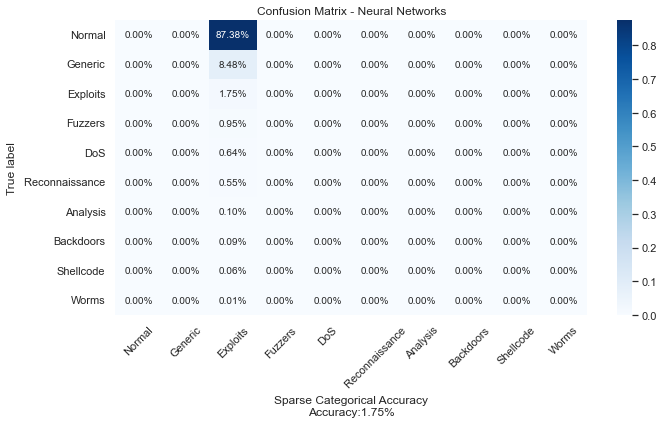

In [10]:
sns.set()
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm/np.sum(cm),annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix - Neural Networks')
ax.set_xlabel(f'Sparse Categorical Accuracy\nAccuracy:{round(acc*100,2)}%')
ax.set_ylabel('True label')

ax.yaxis.set_ticklabels(labels)
ax.xaxis.set_ticklabels(labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(log_file+'/confusion_matrix')
plt.show()